In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




In [194]:
combined_stats = pd.read_csv('Data/FantasyFootball_2025.csv')

In [196]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023Cmp,2023Att,PassYds,2023PassTD,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,6,Lamar Jackson,BAL,QB,26,16,307,457,3678,24,...,6,148.0,952,4,0,0,0,5,40,479.2
1,21,Ja'Marr Chase,CIN,WR,23,16,1,1,-7,0,...,0,3.0,21,0,119,1607,14,0,14,367.1
2,1,Josh Allen,BUF,QB,27,17,385,579,4306,29,...,6,113.0,561,10,0,0,0,2,41,431.3
3,11,Joe Burrow,CIN,QB,27,10,244,365,2309,15,...,9,44.0,190,3,0,0,0,4,42,439.1
4,26,Baker Mayfield,TAM,QB,28,17,364,566,4044,28,...,18,61.0,326,3,0,0,0,3,38,389.7


In [198]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           237 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023Cmp                      281 non-null    int64  
 7   2023Att                      281 non-null    int64  
 8   PassYds                      281 non-null    int64  
 9   2023PassTD                   281 non-null    int64  
 10  2023Int                      281 non-null    int64  
 11  2023RushAtt                  281 non-null    int64  
 12  2023RushYds                  281 non-null    int64  
 13  2023RushTD          

In [200]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [202]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate data using Train, Test, and Split with Random Forest Regressor.

In [205]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model with adjusted parameters
    rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
wr_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
te_features = ['2023PPR', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2025G', '2024PPR']
qb_features = ['2023PPR', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', '2024PPR']



# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_RFR.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 14.843033715986413
RB - Testing MAE: 28.9351817460318

RB - Feature Importances:
        Feature  Importance
19      2024PPR    0.537248
9         2024G    0.080060
1   2023RushAtt    0.071445
10  2024RushAtt    0.064087
0       2023PPR    0.058878
14   2024RecYds    0.033063
18      2025Age    0.021566
2   2023RushYds    0.021508
12   2024RushTD    0.021029
4       2023Rec    0.018238
3    2023RushTD    0.015283
13      2024Rec    0.012163
17  HealthGrade    0.010809
5     2023RecTD    0.009981
11  2024RushYds    0.009853
6         2023G    0.003821
8        2023TD    0.003523
15    2024RecTD    0.003225
7        2023FL    0.002492
16       2024FL    0.001727

WR - Training MAE: 10.823404571163147
WR - Testing MAE: 22.07297936261968

WR - Feature Importances:
        Feature  Importance
19      2024PPR    0.650057
13      2024Rec    0.058976
1   2023RushAtt    0.046541
4       2023Rec    0.035703
2   2023RushYds    0.032518
0       2023PPR    0.032330
18      2025A

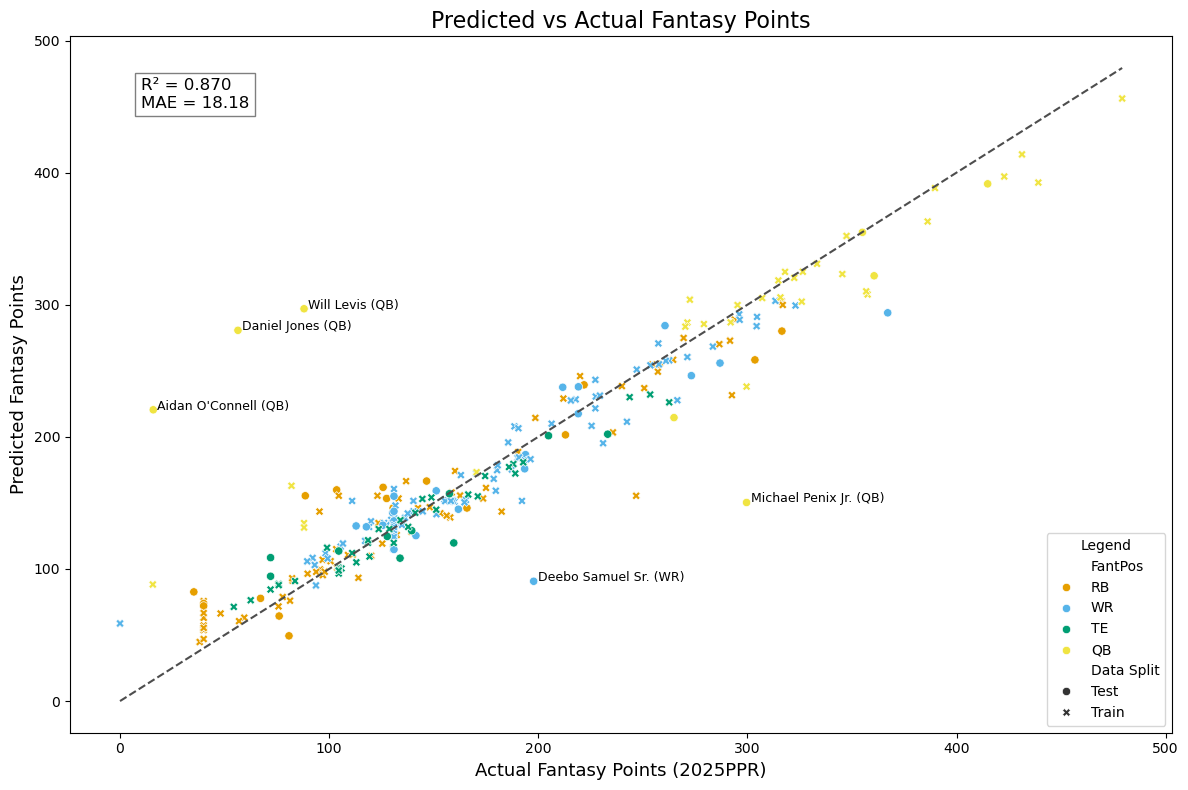

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design / Colorblind safe)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_predictions,
    x='2025PPR', y='Predicted Fantasy Points',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['2025PPR'].min()
max_val = all_predictions['2025PPR'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual Fantasy Points', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

## Now we will use Cross Validation to determine the fantasy football projected scores without the 2025 projected data.

In [210]:
# Function to train and predict for a specific position using cross-validation
def train_and_predict_cv(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features]
    y = position_data['2025PPR']

    # Fill missing values with 0 for simplicity
    X = X.fillna(0)
    y = y.fillna(0)

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)

    # Create a cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Define the scoring method
    mae_scorer = make_scorer(mean_absolute_error)

    # Perform cross-validation
    cv_scores = cross_val_score(rf, X, y, cv=kf, scoring=mae_scorer)

    # Fit the model on the entire dataset after cross-validation
    rf.fit(X, y)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)

    # Calculate the mean MAE from cross-validation
    mean_cv_score = cv_scores.mean()
    print(f"\n{position} - Mean CV MAE: {mean_cv_score}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    return position_data[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
wr_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
te_features = ['2023PPR', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2025G', '2024PPR']
qb_features = ['2023PPR', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', '2024PPR']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict_cv('RB', rb_features)
wr_predictions = train_and_predict_cv('WR', wr_features)
te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Mean CV MAE: 33.69301433654945

RB - Feature Importances:
        Feature  Importance
19      2024PPR    0.673062
9         2024G    0.068822
0       2023PPR    0.044187
12   2024RushTD    0.039350
2   2023RushYds    0.029636
14   2024RecYds    0.021230
1   2023RushAtt    0.017790
18      2025Age    0.016362
4       2023Rec    0.013802
3    2023RushTD    0.012565
17  HealthGrade    0.011716
10  2024RushAtt    0.010896
13      2024Rec    0.010822
5     2023RecTD    0.009235
8        2023TD    0.005884
11  2024RushYds    0.005791
6         2023G    0.004277
7        2023FL    0.001940
16       2024FL    0.001405
15    2024RecTD    0.001227

WR - Mean CV MAE: 27.359989203772425

WR - Feature Importances:
        Feature  Importance
19      2024PPR    0.697873
0       2023PPR    0.048644
13      2024Rec    0.046925
4       2023Rec    0.030671
1   2023RushAtt    0.028408
14   2024RecYds    0.027683
18      2025Age    0.022894
2   2023RushYds    0.020880
9         2024G    0.020114
15 

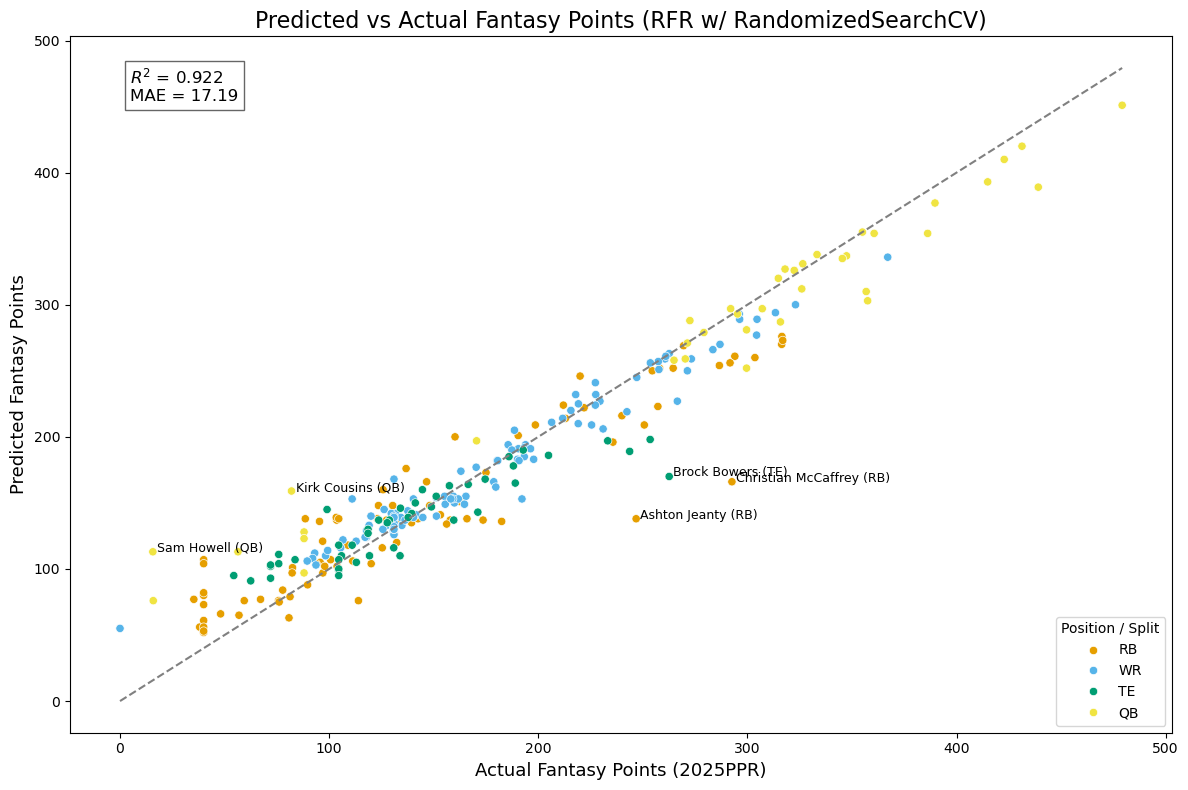

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (RFR w/ RandomizedSearchCV)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

## Function to train and predict for a specific position using RandomizedSearchCV without the 2025 projected data.

In [218]:

def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Define the parameter grid
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Set up the RandomForestRegressor model
    rf = RandomForestRegressor(random_state=42)

    # Set up RandomizedSearchCV with cross-validation
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=30,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Fit the model to the whole data (cross-validation is used internally)
    rf_random_search.fit(X, y)
    best_rf = rf_random_search.best_estimator_

    # Perform cross-validated prediction
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(best_rf, X, y, cv=kf)

    # Calculate and print cross-validated MAE
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"{position} - Cross-Validated MAE: {mae_cv}")

    # Feature importances
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Train final model on full data and generate predictions
    best_rf.fit(X, y)
    position_data['Predicted Fantasy Points'] = np.ceil(best_rf.predict(X))

    # For tracking, label all data as used in CV
    position_data['Data Split'] = 'Cross-Validated'

    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
wr_features = ['2023PPR', '2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024PPR']
te_features = ['2023PPR', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2025G', '2024PPR']
qb_features = ['2023PPR', 'PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', '2024PPR']

# Train and predict for each position
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

# Save the projected data to a new CSV file
output_path = "Data/FantasyFootballPrediction_RSCV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
RB - Cross-Validated MAE: 34.32072666410261

RB - Feature Importances:
        Feature  Importance
19      2024PPR    0.205447
10  2024RushAtt    0.147251
12   2024RushTD    0.145270
0       2023PPR    0.073808
2   2023RushYds    0.072908
13      2024Rec    0.063419
14   2024RecYds    0.054551
1   2023RushAtt    0.044649
8        2023TD    0.032170
3    2023RushTD    0.030528
9         2024G    0.027314
11  2024RushYds    0.023020
15    2024RecTD    0.020775
4       2023Rec    0.016793
18      2025Age    0.010894
5     2023RecTD    0.010600
17  HealthGrade    0.008227
6         2023G    0.007345
7        2023FL    0.003280
16       2024FL    0.001752
Fitting 3 folds for each of 30 candidates, totalling 90 fits
WR - Cross-Validated MAE: 26.45787214787326

WR - Feature Importances:
        Feature  Importance
19      2024PPR    0.243515
13      2024Rec    0.177799
15    2024RecTD    0.090729
0       2023PPR    0.084910
4       

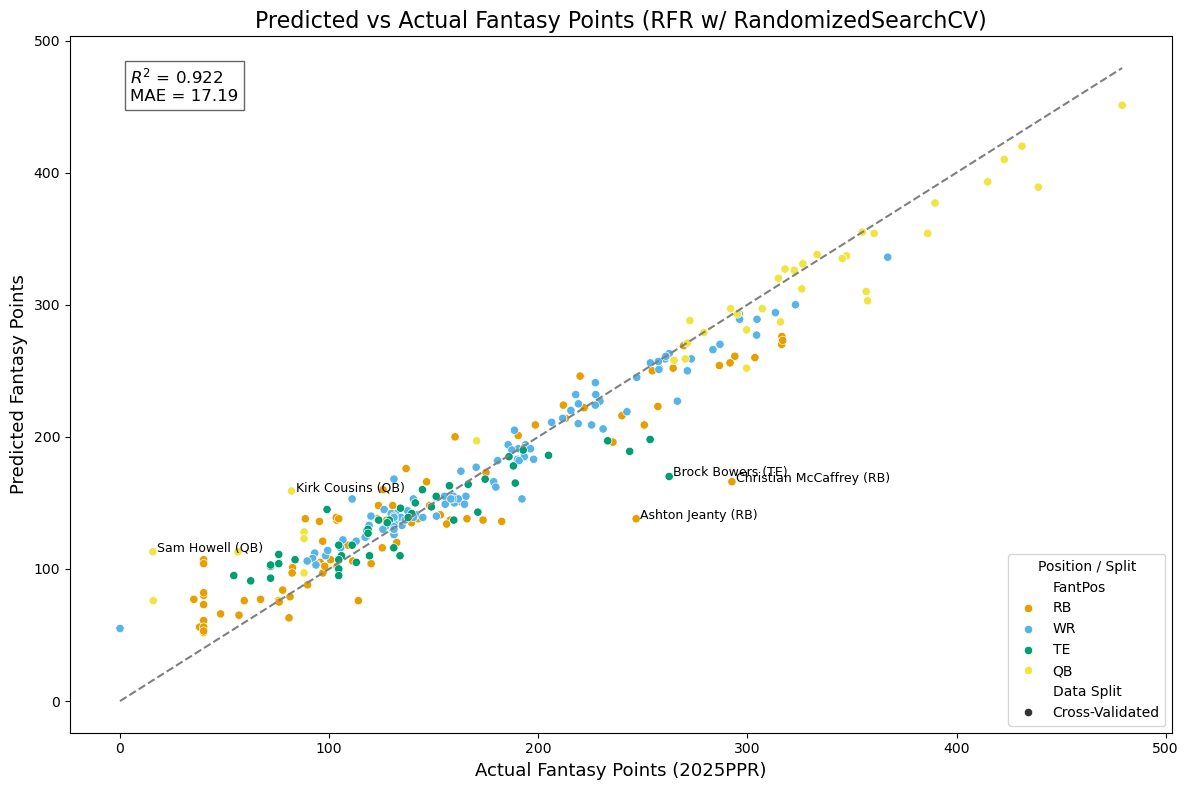

In [220]:

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    style='Data Split',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (RFR w/ RandomizedSearchCV)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()